<a href="https://colab.research.google.com/github/setegnabebe/changePointAnalysis/blob/tasks/analysModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import necessary libraries
! pip install seaborn
! pip install hmmlearn
! pip install statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA

# Set visualization style
sns.set(style="darkgrid")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 3.0 MB/s eta 0:00:00


In [4]:
# Load Brent oil price data
df = pd.read_csv('./data/BrentOilPrices.csv', parse_dates=['Date'], index_col='Date')

# Display first few rows
df.head()


<ipython-input-4-921b7e586768>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('./data/BrentOilPrices.csv', parse_dates=['Date'], index_col='Date')


,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [5]:

def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')

adf_test(df['Price'])

ADF Statistic: -1.9938560113924675
p-value: 0.28927350489340287
Critical Values: {'1%': -3.4310783342658615, '5%': -2.861861876398633, '10%': -2.566941329781918}


In [6]:
# Using 'Price' column for the HMM model
prices = df[['Price']].dropna().values
prices = prices.reshape(-1, 1)

In [8]:
model_hmm = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000)



In [10]:

model_hmm.fit(prices)

GaussianHMM(covariance_type='full', n_components=2, n_iter=1000)

In [13]:
hidden_states = model_hmm.predict(prices)

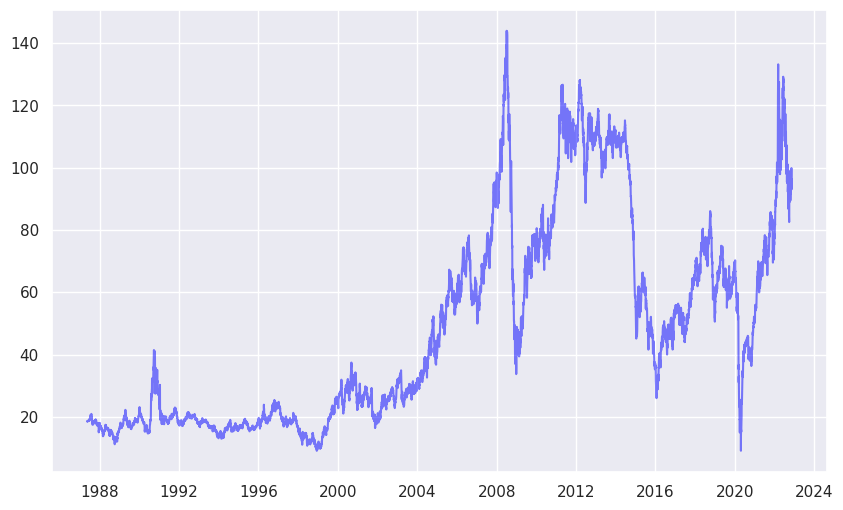

In [14]:
#  Visualize the regimes over time
plt.figure(figsize=(10, 6))
plt.plot(df.index, prices, label='Brent Oil Price', color='blue', alpha=0.5)

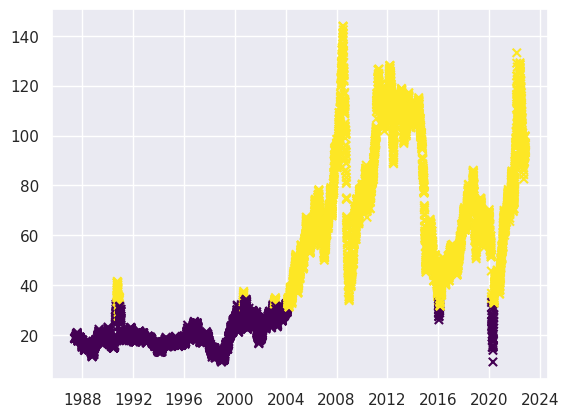

In [15]:
# Plot regime-switching states
plt.scatter(df.index, prices, c=hidden_states, cmap='viridis', label='Regime States', marker='x')

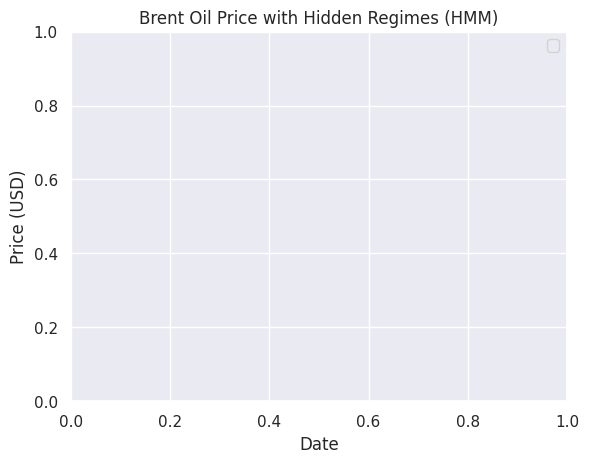

In [16]:
plt.title('Brent Oil Price with Hidden Regimes (HMM)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [17]:
# Simulate future hidden states for the next 30 days
future_steps = 30
future_states = model_hmm.sample(future_steps)[0]

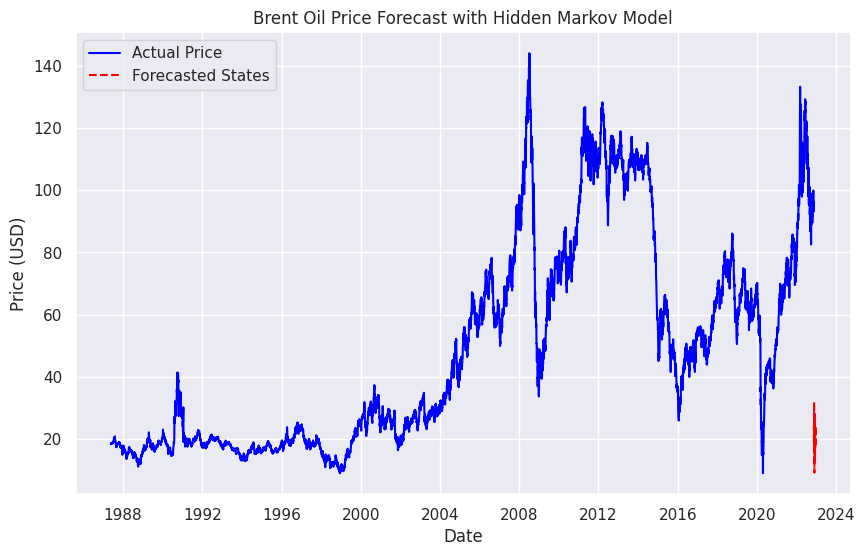

In [18]:
#  Plotting forecasted states
forecast_dates = pd.date_range(start=df.index[-1], periods=future_steps + 1, freq='D')[1:]
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Price'], label='Actual Price', color='blue')
plt.plot(forecast_dates, future_states, label='Forecasted States', color='red', linestyle='--')
plt.title('Brent Oil Price Forecast with Hidden Markov Model')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [19]:
# If necessary, difference the data
df['Price_diff'] = df['Price'].diff().dropna()  # Differencing the data

# Fit the ARIMA model
# p, d, q are the ARIMA orders (p = AR, d = Differencing, q = MA)
# For simplicity, we will use (1,1,1) as example. You can tune these parameters.
model_arima = ARIMA(df['Price'], order=(1, 1, 1))
model_arima_fitted = model_arima.fit()

# Display the summary of the ARIMA model
print(model_arima_fitted.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 9011
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14543.950
Date:                Fri, 08 Nov 2024   AIC                          29093.899
Time:                        10:22:33   BIC                          29115.218
Sample:                             0   HQIC                         29101.153
                               - 9011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3427      0.159     -2.152      0.031      -0.655      -0.031
ma.L1          0.3712      0.157      2.358      0.018       0.063       0.680
sigma2         1.4777      0.008    184.571      0.0

In [20]:
# Forecast the next 30 days using ARIMA
forecast_steps = 30
forecast_arima = model_arima_fitted.forecast(steps=forecast_steps)

# Prepare forecasted dates
forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='D')[1:]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


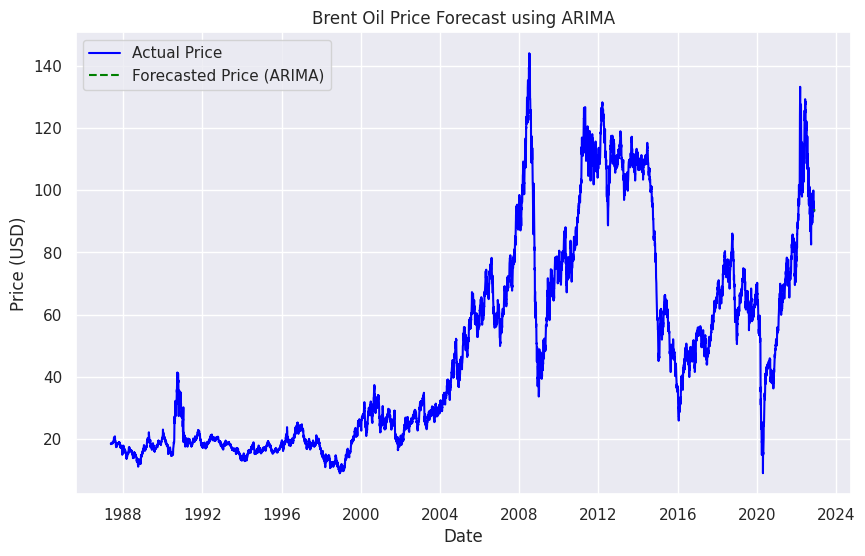

In [21]:
# Step 9.3: Plotting Actual vs Predicted Values using ARIMA
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Price'], label='Actual Price', color='blue')
plt.plot(forecast_dates, forecast_arima, label='Forecasted Price (ARIMA)', color='green', linestyle='--')
plt.title('Brent Oil Price Forecast using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()